 #  Implementación de una red Neuronal desde cero en Python
## $$ Introducción$$

## MSc Rubén Quispe

En este laboratorio implementaremos una red neuronal simple de 3 capas desde cero. No obtendremos todas las matemáticas que se requieren, pero intentaré dar una explicación intuitiva de lo que estamos haciendo. También señalaré recursos para que leas los detalles.

Aquí supongo que está familiarizado con los conceptos básicos de cálculo y Machine Learning, por ejemplo, sabe qué es la clasificación y la regularización. Idealmente, también sabe un poco sobre cómo funcionan las técnicas de optimización como el descenso de gradiente. Pero incluso si no está familiarizado con ninguno de los anteriores, esta publicación podría resultarte interesante.

Pero, ¿por qué implementar una red neuronal desde cero? Incluso si planea usar librerías de redes neuronales como [PyBrain](http://pybrain.org/) en el futuro, implementar una red desde cero al menos una vez es un ejercicio extremadamente valioso. Le ayuda a comprender cómo funcionan las redes neuronales, y eso es esencial para diseñar modelos efectivos.

Una cosa a tener en cuenta es que los ejemplos de código aquí no son terriblemente eficientes. Están destinados a ser fáciles de entender. En una próxima publicación, exploraré cómo escribir una implementación eficiente de la Red Neural usando [Theano](http://deeplearning.net/software/theano/).

## Generando un dataset
Comencemos generando un conjunto de datos con el que podamos jugar. Afortunadamente, [ Scikit-Learn](https://scikit-learn.org/stable/) tiene algunos generadores de conjuntos de datos útiles, por lo que no necesitamos escribir el código nosotros mismos. Iremos con la función [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)

In [1]:
# Package imports 
import matplotlib.pyplot as plt 
import numpy as np 
import sklearn 
import sklearn.datasets 
import sklearn.linear_model 
import matplotlib 

In [13]:
# Mostrar gráficos en linea y cambiar el tamaño de la figura predeterminada
%matplotlib inline
matplotlib.rcParams['figure.figsize']= (10.0,8.0)

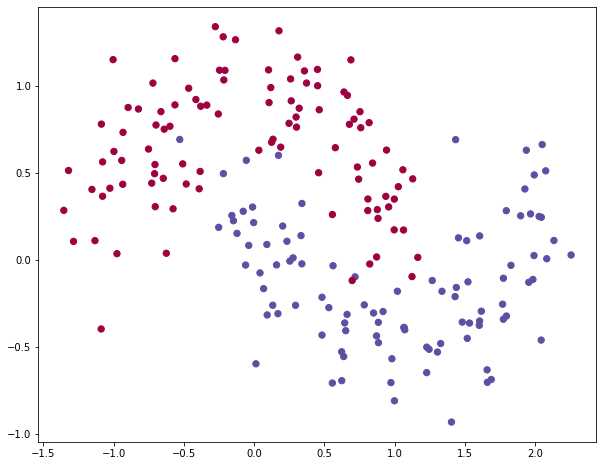

In [14]:
# Generando nuestro dataset y trazar la gráfica

np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


El conjunto de datos que generamos tiene dos clases, trazadas como puntos rojos y azules. Puede pensar en los puntos azules como pacientes masculinos y los puntos rojos como pacientes femeninos, con los ejes x e y como medidas médicas.

Nuestro objetivo es entrenar un clasificador de Machine Learning que prediga la clase correcta (hombre de mujer) dadas las coordenadas x e y. Tenga en cuenta que los datos no son linealmente separables, no podemos dibujar una línea recta que separe las dos clases. Esto significa que los clasificadores lineales, como la Regresión logística, no podrán ajustarse a los datos a menos que diseñes manualmente características no lineales (como los polinomios) que funcionan bien para el conjunto de datos dado.

De hecho, esa es una de las principales ventajas de las redes neuronales. No necesita preocuparse por la [ingeniería de características](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/) La capa oculta de una red neuronal aprenderá características para usted.

# Regresión Logística
Para demostrar el punto, entrenemos un clasificador de regresión logística. Su entrada será los valores x e y la salida la clase predicha (0 o 1). Para facilitarnos la vida, utilizamos la clase Regresión logística de scikit-learn .

In [4]:
# entrenar el clasificiador de regresión Logística
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)


C:\Users\RUBEN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [5]:
# Helper function to plot a decision boundary. 
# Si no comprende completamente esta función, no se preocupe, solo genera el diagrama de contorno a continuación.
def plot_decision_boundary(pred_func): 
    # Set min and max values and give it some padding 
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 
    h = 0.01 
    # Generate a grid of points with distance h between them 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    # Predict the function value for the whole gid 
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) 
    # Plot the contour and training examples 
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral) 
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral) 

Text(0.5, 1.0, 'Logistic Regression')

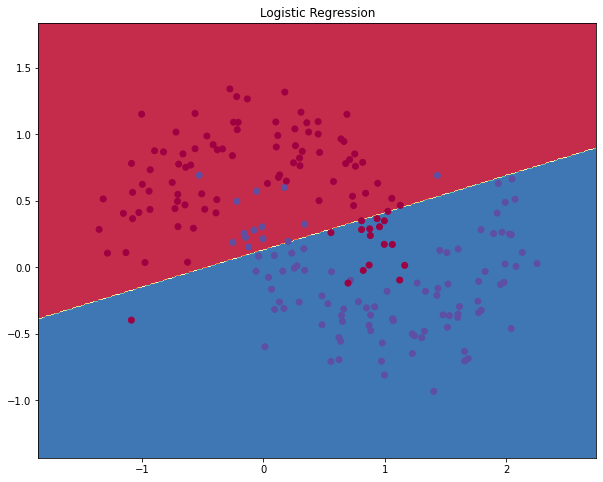

In [6]:
# Plot the decision boundary 
plot_decision_boundary(lambda x: clf.predict(x)) 
plt.title("Logistic Regression")

El gráfico muestra el límite de decisión aprendido por nuestro clasificador de Regresión logística. Separa los datos lo mejor que puede usando una línea recta, pero no puede capturar la "forma de luna" de nuestros datos.

## Entrenando una red neuronal
Ahora construyamos una red neuronal de 3 capas con una capa de entrada, una capa oculta y una capa de salida. La cantidad de nodos en la capa de entrada está determinada por la dimensionalidad de nuestros datos, 2. De manera similar, la cantidad de nodos en la capa de salida está determinada por la cantidad de clases que tenemos, también 2. (Debido a que solo tenemos 2 clases, en realidad podría salirse con solo un nodo de salida que predice 0 o 1, pero tener 2 hace que sea más fácil extender la red a más clases más adelante). La entrada a la red será coordenadas x e y, y su salida será dos probabilidades, una para la clase 0 ("hembra") y otra para la clase 1 ("macho"). Se ve algo como esto:

<img src ="http://www.wildml.com/wp-content/uploads/2015/09/nn-from-scratch-3-layer-network.png"/>

Podemos elegir la dimensionalidad (el número de nodos) de la capa oculta. Cuantos más nodos coloquemos en la capa oculta, más funciones complejas podremos ajustar. Pero una mayor dimensionalidad tiene un costo. Primero, se requiere más cómputo para hacer predicciones y aprender los parámetros de la red. Un mayor número de parámetros también significa que somos más propensos a sobreajustar (overfitting) nuestros datos.

¿Cómo elegir el tamaño de la capa oculta? Si bien hay algunas pautas y recomendaciones generales, siempre depende de su problema específico y es más un arte que una ciencia. Más tarde jugaremos con el número de nodos en la capa oculta y veremos cómo afecta a nuestra salida.

También debemos elegir una función de activación para nuestra capa oculta. La función de activación transforma las entradas de la capa en sus salidas. Una función de activación no lineal es lo que nos permite ajustar hipótesis no lineales. Las opciones comunes para las funciones de activación son [tanh](https://reference.wolfram.com/language/ref/Tanh.html) , la [función sigmoidea](https://en.wikipedia.org/wiki/Sigmoid_function) o [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). Usaremos tanh , que funciona bastante bien en muchos escenarios. Una buena propiedad de estas funciones es que su derivada se puede calcular utilizando el valor de la función original. Por ejemplo, la derivada de  $tanx$ es $1-tan^2x$. Esto es útil porque nos permite calcular tanx una vez y reutilizar su valor más adelante para obtener la derivada.

Debido a que queremos que nuestra red genere probabilidades, la función de activación para la capa de salida será el [softmax](https://en.wikipedia.org/wiki/Softmax_function), que es simplemente una forma de convertir puntajes brutos en probabilidades. Si está familiarizado con la función logística, puede pensar en softmax como su generalización a múltiples clases.

## Cómo nuestra red hace predicciones
Nuestra red realiza predicciones utilizando la propagación hacia adelante, que es solo un montón de multiplicaciones matriciales y la aplicación de las funciones de activación que definimos anteriormente. Si x es la entrada bidimensional de nuestra red, calculamos nuestra predicción {y}(también bidimensional) de la siguiente manera:
$$z_1 =xW_1 +b_1$$
$$a_1 = tan(z_1)$$
$$ z_2 =a_1W_2 + b_2$$
$$ a_2 =\hat{y} = softmax(z_2)$$

$z_i$ es la capa de entrada $i$ y $a_i$ es la capa de salida $i$ despues aplicamos la función de activación. $ W_1,b_1, b_2$ son parámetros de nuestra red, que necesitamos aprender de nuestros datos de entrenamiento. Puede pensar en ellas como matriz como matrices que transforman datos entre capas de red. Si observamos las multiplicaciones matriciales anteriores, podemos determinar la dimensionalidad de estas matrices. Si usamos 500 nodos para nuestar capa oculta. Ahora puede ver por qué tenemos más parámetros si aumentamos el tamaño de la capa oculta entonces $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. Ahora puede ver por qué tenemos más parámetros si aumentamos el tamaño de la capa oculta.

## Aprendiendo los parámetros
Aprender los parámetros para nuestra red significa encontrar parámetros $( W_1, b_1, W_2, b_2)$ que minimicen el error en nuestros datos de entrenamiento. Pero, ¿cómo definimos el error? Llamamos a la función que mide nuestro error la función de pérdida. Una opción común con la salida de softmax es la pérdida categórica  de [entropía cruzada](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression) (también conocida como probabilidad de registro negativa). Si tenemos  N ejemplos de entrenamiento y C clases entonces la pérdida de nuestra predicción $\hat{y}$ con respecto a las etiquetas verdaderas $y$ viene dada por:
$$ L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} sum_{i \in C} y_{n,i} \log\hat{y}_{n,i} $$

La fórmula parece complicada, pero todo lo que realmente hace es resumir nuestros ejemplos de entrenamiento y aumentar la pérdida si predijimos la clase incorrecta. Cuanto más lejos estén las dos distribuciones de probabilidad y (las etiquetas correctas) y $ \hat{y}$ (nuestras predicciones), mayor será nuestra pérdida. Al encontrar parámetros que minimicen la pérdida, maximizamos la probabilidad de nuestros datos de entrenamiento.

Podemos usar el ¨[descenso de gradiente](https://cs231n.github.io/optimization-1/) para encontrar el mínimo e implementaré la versión más vainilla de descenso de gradiente, también llamada descenso de gradiente por lotes con una tasa de aprendizaje fija. Las variaciones como el SGD (descenso de gradiente estocástico) o el descenso de gradiente minibatch suelen funcionar mejor en la práctica. Entonces, si eres serio, querrás usar uno de estos, e idealmente también [disminuirías la tasa de aprendizaje con el tiempo](https://cs231n.github.io/neural-networks-3/#anneal)

Como una entrada, descenso de gradiente necesita los gradientes (vector de derivados) de la función de pérdida con respecto a nuestros parámetros: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$.
Para calcular estos gradientes, utilizamos el famoso algoritmo de retropropagación , que es una forma de calcular eficientemente los gradientes a partir de la salida. No entraré en detalles sobre cómo funciona la retropropagación, pero hay muchas explicaciones excelentes ( [aquí](https://cs231n.github.io/optimization-2/) ) flotando en la web.

Aplicando la fórmula de retropropagación encontramos lo siguiente (confía en mí en esto):

$$  \delta_3 = \hat{y} - y \\
\delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
 \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
 \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
 \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
 \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\  $$

## Implementación
Ahora estamos listos para nuestra implementación. Comenzamos definiendo algunas variables y parámetros útiles para el descenso de gradiente:

In [21]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

Primero implementemos la función de pérdida que definimos anteriormente. Usamos esto para evaluar qué tan bien está funcionando nuestro modelo:

In [22]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

También implementamos una función auxiliar para calcular la salida de la red. Realiza la propagación como se definió anteriormente y devuelve la clase con la mayor probabilidad.

In [23]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

Finalmente, aquí viene la función de entrenar nuestra red neuronal. Implementa el descenso de gradiente por lotes utilizando los derivados de retropropagación que encontramos arriba.

In [25]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # Este es lo que volvemos al final
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 y b2 no tienen términos de regularización)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

## Una red con una capa oculta de tamaño 3
Veamos qué sucede si entrenamos una red con un tamaño de capa oculta de 3.

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068890
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

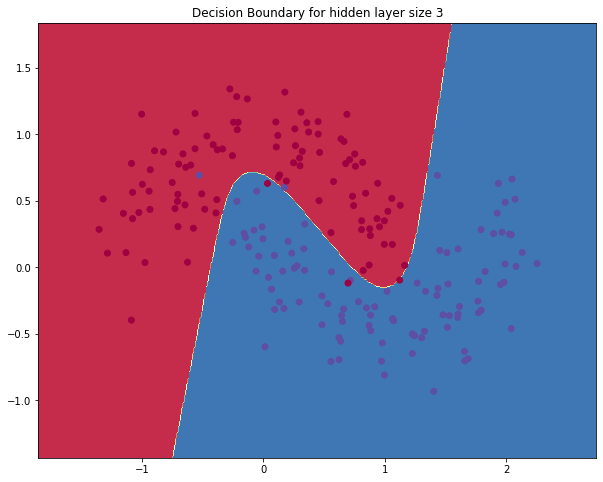

In [26]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

¡Hurra! Esto se ve bastante bien. Nuestras redes neuronales pudieron encontrar un límite de decisión que separa con éxito las clases.

## Variando el tamaño de la capa oculta
En el ejemplo anterior, elegimos un tamaño de capa oculta de 3. Ahora veamos cómo varía el tamaño de la capa oculta en el resultado.

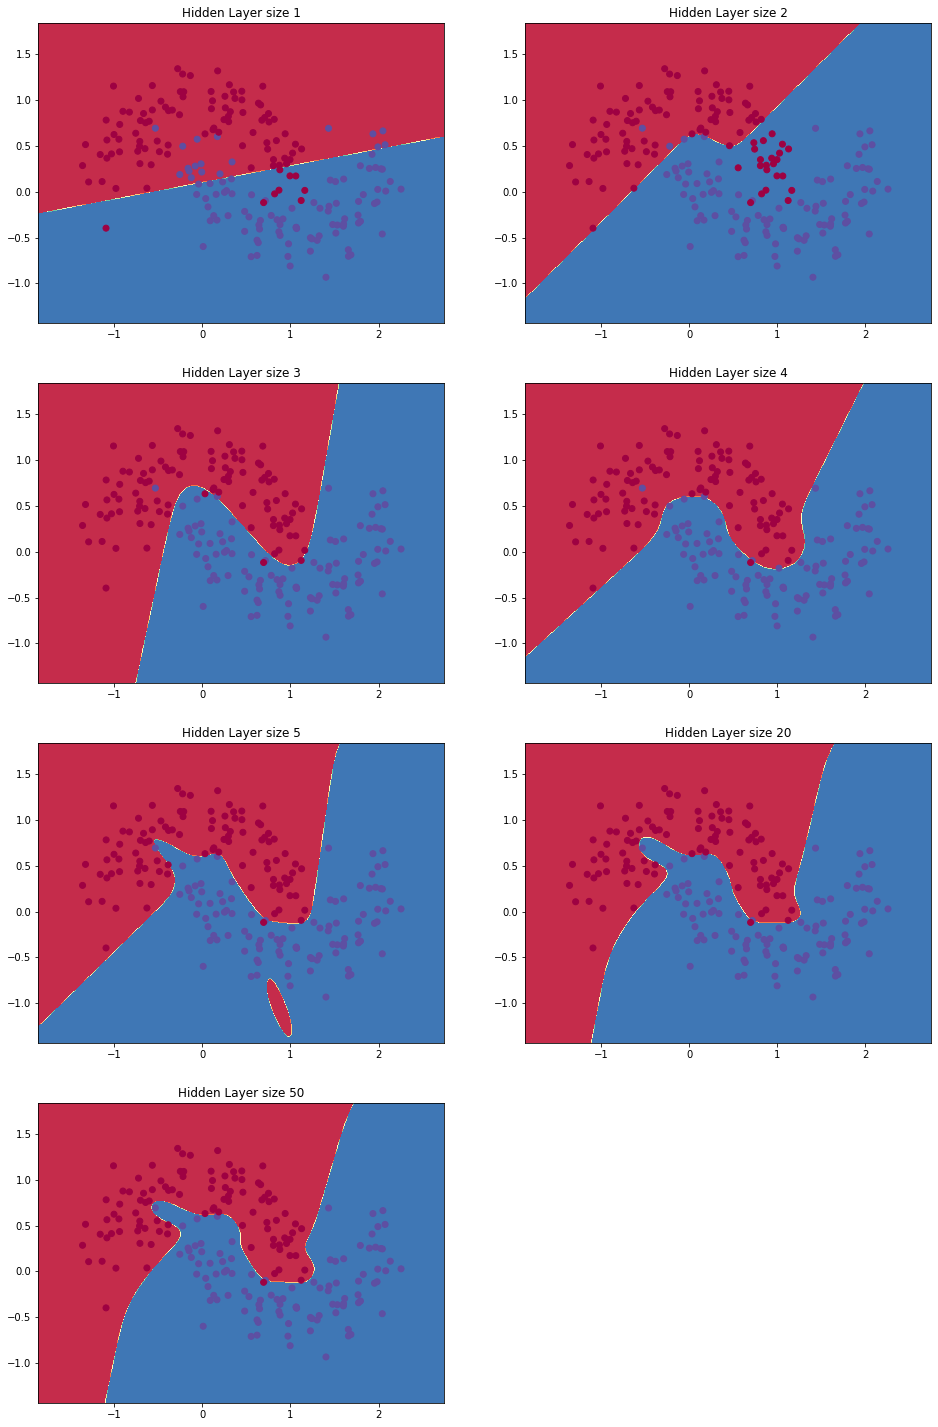

In [27]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

Podemos ver que una capa oculta de baja dimensionalidad captura muy bien la tendencia general de nuestros datos. Las dimensionalidades más altas son propensas al sobreajuste. Están "memorizando" los datos en lugar de ajustar la forma general. Si tuviéramos que evaluar nuestro modelo en un conjunto de prueba separado (¡y usted debería hacerlo!), El modelo con un tamaño de capa oculta más pequeño probablemente funcionaría mejor debido a una mejor generalización. Podríamos contrarrestar el sobreajuste con una regularización más fuerte, pero elegir el tamaño correcto para la capa oculta es una solución mucho más "económica".

## Ejercicios
Aquí hay algunas cosas que puede intentar para familiarizarse con el código:

1. En lugar del descenso de gradiente por lotes, use el descenso de gradiente de minibatch ( [más información](https://cs231n.github.io/optimization-1/#gd) ) para entrenar la red. El descenso del gradiente de minibatch generalmente funciona mejor en la práctica.
2. Utilizamos una tasa de aprendizaje fija  $\epsilon$ para el descenso de gradiente. Implemente un cronograma de recocido para la tasa de aprendizaje de descenso de gradiente ( [más información](https://cs231n.github.io/neural-networks-3/#anneal) ).
3. Utilizamos una $tan$ función de activación para nuestra capa oculta. Experimente con otras funciones de activación (algunas se mencionan anteriormente). Tenga en cuenta que cambiar la función de activación también significa cambiar la derivada de retropropagación.
4. Extienda la red de dos a tres clases. Necesitará generar un conjunto de datos apropiado para esto.
5. Extienda la red a cuatro capas. Experimente con el tamaño de la capa. Agregar otra capa oculta significa que necesitará ajustar tanto la propagación hacia adelante como el código de propagación hacia atrás.

# GRACIAS